In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

# XAI Tools
import shap
from lime.lime_tabular import LimeTabularExplainer

In [58]:
df = pd.read_csv('/kaggle/input/credit-score-classification/train.csv')


Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.


In [59]:

print("\nDataset Info:")
df.info()




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              8859

In [60]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [61]:

df.isnull().sum()


ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [62]:
df.duplicated().sum()


0

In [63]:
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


ID: 100000 unique values
Customer_ID: 12500 unique values
Month: 8 unique values
Name: 10139 unique values
Age: 1788 unique values
SSN: 12501 unique values
Occupation: 16 unique values
Annual_Income: 18940 unique values
Num_of_Loan: 434 unique values
Type_of_Loan: 6260 unique values
Num_of_Delayed_Payment: 749 unique values
Changed_Credit_Limit: 4384 unique values
Credit_Mix: 4 unique values
Outstanding_Debt: 13178 unique values
Credit_History_Age: 404 unique values
Payment_of_Min_Amount: 3 unique values
Amount_invested_monthly: 91049 unique values
Payment_Behaviour: 7 unique values
Monthly_Balance: 98792 unique values
Credit_Score: 3 unique values


In [64]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# Drop high-cardinality or identifier columns
df = df.drop(columns=[
    'ID', 'Customer_ID', 'Name', 'SSN'
])

# Handle target variable
le = LabelEncoder()
df['Credit_Score'] = le.fit_transform(df['Credit_Score'])

# One-hot encode low-cardinality nominal features
one_hot_cols = ['Month', 'Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Label encode ordinal feature
credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2, 'Excellent': 3}
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_map)

# Target encode high-cardinality categorical feature
target_encoder = ce.TargetEncoder()
df['Type_of_Loan'] = target_encoder.fit_transform(df['Type_of_Loan'], df['Credit_Score'])

# OPTIONAL: Clean and convert 'Credit_History_Age' if needed
# For example, if it's in the format "12 Years and 5 Months":
def convert_credit_age(val):
    try:
        years = int(val.split(" ")[0])
        months = int(val.split(" ")[3])
        return years * 12 + months
    except:
        return None

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_age)

# Fill any remaining NaNs (customize if needed)
df = df.fillna(df.mean(numeric_only=True))


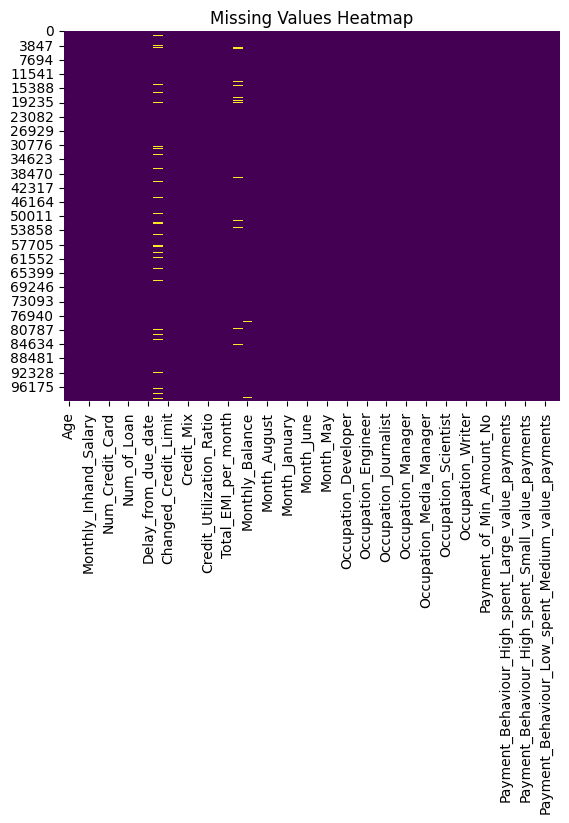

In [65]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


In [66]:
print(df.dtypes)

Age                                                    object
Annual_Income                                          object
Monthly_Inhand_Salary                                 float64
Num_Bank_Accounts                                       int64
Num_Credit_Card                                         int64
Interest_Rate                                           int64
Num_of_Loan                                            object
Type_of_Loan                                          float64
Delay_from_due_date                                     int64
Num_of_Delayed_Payment                                 object
Changed_Credit_Limit                                   object
Num_Credit_Inquiries                                  float64
Credit_Mix                                            float64
Outstanding_Debt                                       object
Credit_Utilization_Ratio                              float64
Credit_History_Age                                    float64
Total_EM

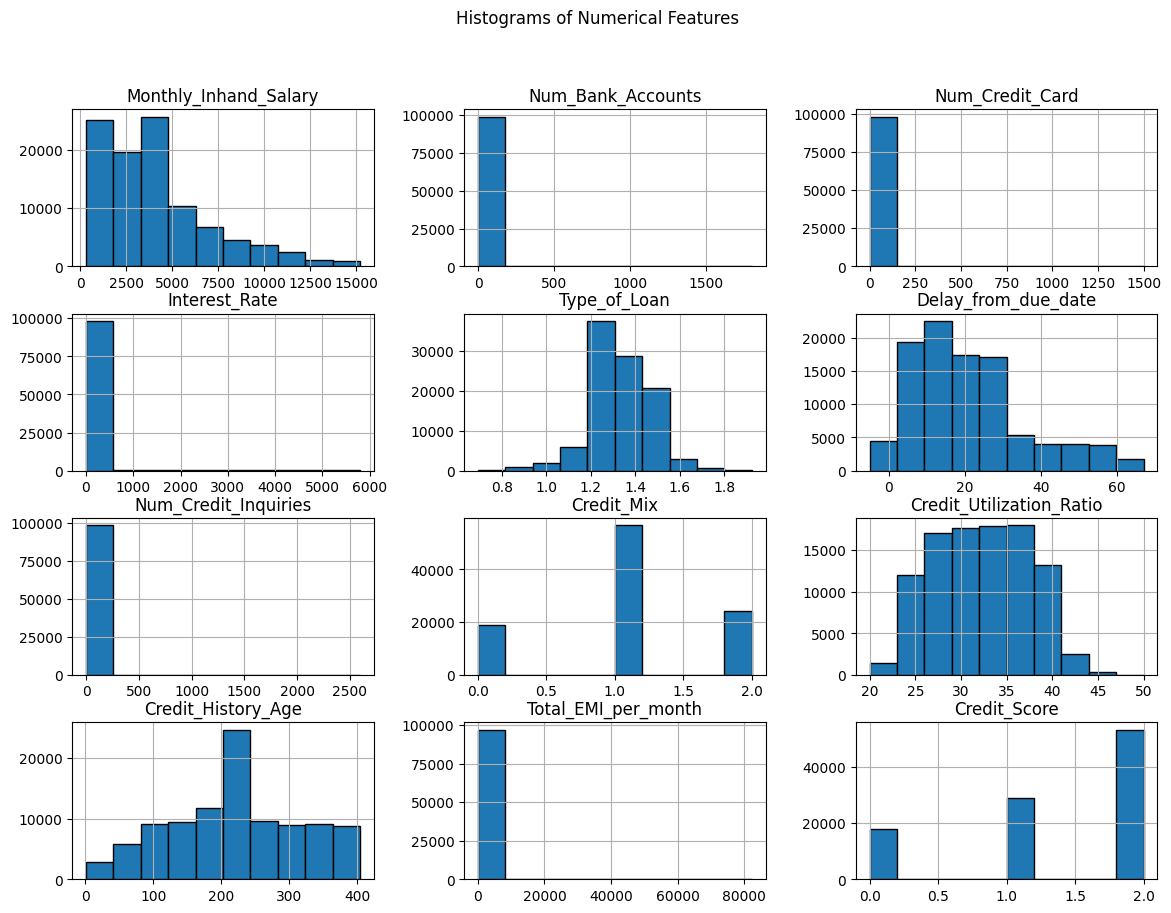

In [67]:

df.hist(figsize=(14,10), edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()





In [68]:
categorical_features = df.select_dtypes(include='object').columns
for col in categorical_features:
    print(f"\nValue Counts for {col}:\n", df[col].value_counts(normalize=True))


Value Counts for Age:
 Age
38      0.02833
28      0.02829
31      0.02806
26      0.02792
32      0.02749
         ...   
471     0.00001
1520    0.00001
8663    0.00001
3363    0.00001
1342    0.00001
Name: proportion, Length: 1788, dtype: float64

Value Counts for Annual_Income:
 Annual_Income
36585.12     0.00016
20867.67     0.00016
17273.83     0.00016
9141.63      0.00015
33029.66     0.00015
              ...   
20269.93_    0.00001
15157.25_    0.00001
44955.64_    0.00001
76650.12_    0.00001
4262933.0    0.00001
Name: proportion, Length: 18940, dtype: float64

Value Counts for Num_of_Loan:
 Num_of_Loan
3        0.14386
2        0.14250
4        0.14016
0        0.10380
1        0.10083
          ...   
1320_    0.00001
103      0.00001
1444     0.00001
392      0.00001
966      0.00001
Name: proportion, Length: 434, dtype: float64

Value Counts for Num_of_Delayed_Payment:
 Num_of_Delayed_Payment
19      0.057281
17      0.056571
16      0.055625
10      0.055410
18      0.0

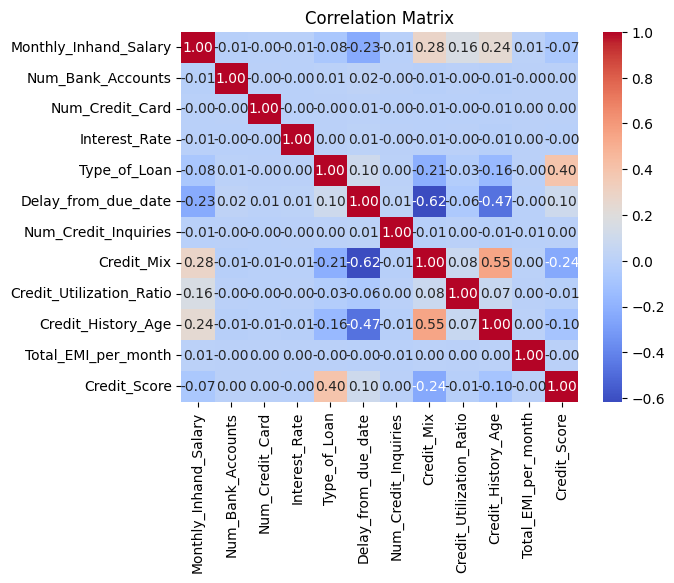

In [69]:
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
corr = df[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



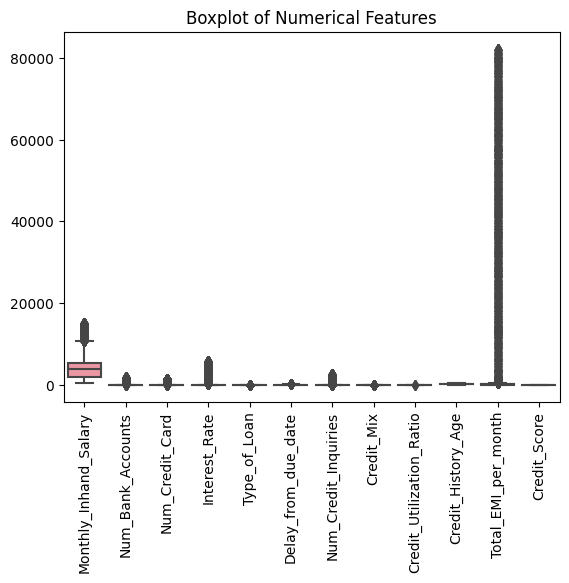

In [70]:
sns.boxplot(data=df[numerical_features])
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=90)
plt.show()



In [71]:
# Make sure changes apply to the actual DataFrame
object_cols = df.select_dtypes(include='object').columns
print(object_cols)
for col in object_cols:
    print('yes')
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert or set NaN


Index(['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
       'Monthly_Balance'],
      dtype='object')
yes
yes
yes
yes
yes
yes
yes
yes


In [72]:
# Separate X and y
X = df.drop(columns='Credit_Score')
y = df['Credit_Score']
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col].fillna(X[col].median(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)

# Handle missing values in y
y.fillna(y.mode()[0], inplace=True)


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [84]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 49)
(80000,)
(20000, 49)
(20000,)


In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))

y_proba = lr.predict_proba(X_test)
print("AUC:", roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))


Logistic Regression
Accuracy: 0.5487
Precision: 0.44993292189259065
Recall: 0.5487
AUC: 0.6221759802502767


lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [98]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
y_proba = dt.predict_proba(X_test)
print("AUC:", roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))

Decision Tree
Accuracy: 0.74165
Precision: 0.7414143344069393
Recall: 0.74165
AUC: 0.7792665838869205


In [99]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
y_proba = rf.predict_proba(X_test)
print("AUC:", roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))

Random Forest
Accuracy: 0.807
Precision: 0.8068277530024154
Recall: 0.807
AUC: 0.9193831847234007


In [101]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB(var_smoothing=0.01)  # corresponds to alpha=0.01 Laplacian smoothing
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
y_proba = nb.predict_proba(X_test)
print("AUC:", roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))

Naive Bayes
Accuracy: 0.52995
Precision: 0.2808470025
Recall: 0.52995
AUC: 0.581172896998989


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [103]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("KNN")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
y_proba = knn.predict_proba(X_test)
print("AUC:", roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))

KNN
Accuracy: 0.66
Precision: 0.6590443580728306
Recall: 0.66
AUC: 0.7909251318843475


In [106]:
results = {
    "Logistic Regression": accuracy_score(y_test, lr.predict(X_test)),
    "Decision Tree": accuracy_score(y_test, dt.predict(X_test)),
    "Random Forest": accuracy_score(y_test, rf.predict(X_test)),
    "Naive Bayes": accuracy_score(y_test, nb.predict(X_test)),
    "K-Nearest Neighbors": accuracy_score(y_test, knn.predict(X_test))
}

# Print accuracies sorted from highest to lowest
print("\nAccuracy Comparison:")
for model, acc in sorted(results.items(), key=lambda item: item[1], reverse=True):
    print(f"{model}: {acc:.4f}")



Accuracy Comparison:
Random Forest: 0.8070
Decision Tree: 0.7417
K-Nearest Neighbors: 0.6600
Logistic Regression: 0.5487
Naive Bayes: 0.5300


In [107]:
pip install shap matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [108]:
X_test = pd.DataFrame(X_test, columns=X.columns)  # if X is your original DataFrame


In [ ]:
import shap
#SHAP summary plot which features are most important and how they push predictions (blue = low, red = high).
# Initialize SHAP explainer for Random Forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Summary Plot (global importance + direction)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

#Force plot for a single prediction (local explanation)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Feature importance plot relative importance of features across all trees.


# Get feature importances
importances = rf.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Random Forest - Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
#PDP: how changing one feature (while keeping others constant) affects the prediction probability.

# Choose top 2 important features
top_features = [features[i] for i in importances.argsort()[-2:]]

# Plot partial dependence
PartialDependenceDisplay.from_estimator(rf, X_test, top_features, kind="average")
plt.suptitle("Partial Dependence Plot (PDP)")
plt.tight_layout()
plt.show()
